In [1]:
# Cell 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from pathlib import Path
import joblib

# find a user_features file automatically (csv or parquet)
proj = Path.cwd()
candidates = list(proj.rglob("user_features*"))
if not candidates:
    raise FileNotFoundError("No user_features file found in project. Save it as user_features.csv or user_features.parquet in the project root or data folder.")
path = candidates[0]
print("Loading:", path)
if path.suffix in [".parquet", ".pq"]:
    df = pd.read_parquet(path)
else:
    df = pd.read_csv(path)
print("Loaded shape:", df.shape)
df.head(3)


Loading: c:\Users\sniki\OneDrive\Desktop\Insider Threat Anamoly Detection\Notebook\user_features.csv
Loaded shape: (1000, 14)


,user,total_logins,unique_days,after_hours,unique_machines,usb_count,usb_days,employee_name,user_id,O,C,E,A,N
0,AAE0190,37,19,0,1,0.0,0.0,August Armando Evans,AAE0190,36,30,14,50,29
1,AAF0535,37,19,0,1,0.0,0.0,Athena Amelia Foreman,AAF0535,17,21,36,33,31
2,AAF0791,37,19,0,1,0.0,0.0,Aladdin Abraham Foley,AAF0791,14,40,40,50,34


In [2]:
# Cell 2
# Identify user identifier column (try common names). If none, use index.
id_col = None
for candidate in ["user", "user_id", "employee_id", "username"]:
    if candidate in df.columns:
        id_col = candidate
        break

if id_col is None:
    # if there's an index that looks like user, use it
    df = df.reset_index().rename(columns={"index":"user"})
    id_col = "user"

print("Using id column:", id_col)
print(df.info())
# Show numeric features count
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric features:", len(numeric_cols))


Using id column: user
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user             1000 non-null   object 
 1   total_logins     1000 non-null   int64  
 2   unique_days      1000 non-null   int64  
 3   after_hours      1000 non-null   int64  
 4   unique_machines  1000 non-null   int64  
 5   usb_count        1000 non-null   float64
 6   usb_days         1000 non-null   float64
 7   employee_name    1000 non-null   object 
 8   user_id          1000 non-null   object 
 9   O                1000 non-null   int64  
 10  C                1000 non-null   int64  
 11  E                1000 non-null   int64  
 12  A                1000 non-null   int64  
 13  N                1000 non-null   int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 109.5+ KB
None
Numeric features: 11


In [3]:
# Cell 3
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
import joblib
import os
import numpy as np

# make sure models/ folder exists
os.makedirs("models", exist_ok=True)

# keep the ids separate
ids = df[id_col].astype(str).reset_index(drop=True)

# numeric features only (drop id and non-numeric)
X_df = df.drop(columns=[id_col])
X_df = X_df.select_dtypes(include=[np.number])
feature_names = X_df.columns.tolist()
print("Features used:", feature_names)

# impute (median) and robust scale
imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X_df)         # shape: (n_samples, n_features)

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_imp)

# save transformers
joblib.dump(imputer, "models/imputer.joblib")
joblib.dump(scaler, "models/scaler.joblib")
print("Imputer & scaler saved.")


Features used: ['total_logins', 'unique_days', 'after_hours', 'unique_machines', 'usb_count', 'usb_days', 'O', 'C', 'E', 'A', 'N']
Imputer & scaler saved.


In [4]:
# Cell 4
from sklearn.decomposition import PCA

pca_n = min(10, X_scaled.shape[1])   # keep up to 10 components (or fewer)
pca = PCA(n_components=pca_n, random_state=42)
X_pca = pca.fit_transform(X_scaled)
joblib.dump(pca, "models/pca.joblib")
print("PCA saved. Components:", pca_n)


PCA saved. Components: 10


In [5]:
# Cell 5
from sklearn.ensemble import IsolationForest

# tune these for performance: n_estimators lower = faster, contamination is expected fraction of anomalies
clf = IsolationForest(n_estimators=200, contamination=0.01, random_state=42, n_jobs=-1)
# Fit on full scaled features (X_scaled). If very slow, fit on X_pca instead.
clf.fit(X_scaled)

# score_samples: higher = more normal (sklearn). We invert to make "anomaly score" where higher = more anomalous
raw_scores = clf.score_samples(X_scaled)   # higher = more normal
iso_score = -raw_scores                    # higher = more anomalous
iso_pred = clf.predict(X_scaled)           # -1 = anomaly, 1 = normal

# Save model
joblib.dump(clf, "models/isolation_forest.joblib")
print("IsolationForest trained and saved.")
# Cell 5
from sklearn.ensemble import IsolationForest

# tune these for performance: n_estimators lower = faster, contamination is expected fraction of anomalies
clf = IsolationForest(n_estimators=200, contamination=0.01, random_state=42, n_jobs=-1)
# Fit on full scaled features (X_scaled). If very slow, fit on X_pca instead.
clf.fit(X_scaled)

# score_samples: higher = more normal (sklearn). We invert to make "anomaly score" where higher = more anomalous
raw_scores = clf.score_samples(X_scaled)   # higher = more normal
iso_score = -raw_scores                    # higher = more anomalous
iso_pred = clf.predict(X_scaled)           # -1 = anomaly, 1 = normal

# Save model
joblib.dump(clf, "models/isolation_forest.joblib")
print("IsolationForest trained and saved.")


IsolationForest trained and saved.
IsolationForest trained and saved.


In [6]:
# Cell 6
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.01)
# fit on PCA to speed up (X_pca). If you didn't create PCA, set X_used = X_scaled
X_used = X_pca if X_pca.shape[1] > 0 else X_scaled
lof.fit(X_used)
lof_scores = -lof.decision_function(X_used)   # invert so higher = more anomalous
lof_pred = lof.predict(X_used)                 # -1 anomaly, 1 normal

joblib.dump(lof, "models/lof.joblib")
print("LOF trained and saved.")


LOF trained and saved.


In [7]:
# Cell 7 (optional)
from sklearn.svm import OneClassSVM
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.01)
# fit on PCA for speed
ocsvm.fit(X_used)
svm_scores = -ocsvm.decision_function(X_used)  # invert so higher = more anomalous
svm_pred = ocsvm.predict(X_used)               # -1 anomaly, 1 normal
joblib.dump(ocsvm, "models/oneclass_svm.joblib")
print("One-Class SVM trained and saved.")


One-Class SVM trained and saved.


In [8]:
# Cell 8 (optional)
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

input_dim = X_scaled.shape[1]
enc_units = max(8, min(128, input_dim*2))

inp = layers.Input(shape=(input_dim,))
x = layers.Dense(enc_units, activation='relu')(inp)
x = layers.Dense(enc_units//2, activation='relu')(x)
bottleneck = layers.Dense(max(4, enc_units//4), activation='relu')(x)
x = layers.Dense(enc_units//2, activation='relu')(bottleneck)
x = layers.Dense(enc_units, activation='relu')(x)
out = layers.Dense(input_dim, activation=None)(x)
ae = models.Model(inp, out)
ae.compile(optimizer='adam', loss='mse')

es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Train — if slow set epochs=20, batch_size=256 or smaller
ae.fit(X_scaled, X_scaled, epochs=50, batch_size=256, validation_split=0.1, callbacks=[es], verbose=1)

recon = ae.predict(X_scaled)
ae_mse = np.mean(np.square(X_scaled - recon), axis=1)
ae.save("models/autoencoder.keras")
print("Autoencoder trained and saved.")


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 11.8112 - val_loss: 11.8051
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 11.6129 - val_loss: 11.6150
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 11.4350 - val_loss: 11.4347
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11.2655 - val_loss: 11.2444
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11.0757 - val_loss: 11.0388
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10.8581 - val_loss: 10.7978
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10.6006 - val_loss: 10.5166
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10.2931 - val_loss: 10.1887
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.9831 - val_loss: 9.7949
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.5861 - val_loss: 9.3457
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.0940 - val_loss: 8.8383
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.5721 - va

In [9]:
# Cell 9
from sklearn.preprocessing import MinMaxScaler

results = pd.DataFrame({"user": ids})
results["iso_score"] = iso_score
results["iso_pred"] = iso_pred

# If you computed LOF / SVM / AE, add them (check existence)
try:
    results["lof_score"] = lof_scores
    results["lof_pred"] = lof_pred
except NameError:
    results["lof_score"] = np.nan
try:
    results["svm_score"] = svm_scores
    results["svm_pred"] = svm_pred
except NameError:
    results["svm_score"] = np.nan
try:
    results["ae_mse"] = ae_mse
except NameError:
    results["ae_mse"] = np.nan

# Normalize the available score columns (higher = more anomalous)
norm_cols = [c for c in ["iso_score","lof_score","svm_score","ae_mse"] if c in results.columns]
scaler_scores = MinMaxScaler()
results["combined_score"] = scaler_scores.fit_transform(results[norm_cols].fillna(0)) .mean(axis=1)

# rank
results = results.sort_values("combined_score", ascending=False).reset_index(drop=True)
results.head(20)


,user,iso_score,iso_pred,lof_score,lof_pred,svm_score,svm_pred,ae_mse,combined_score
0,BSS0369,0.713318,-1,0.565837,-1,0.314409,-1,1.125761,0.997012
1,WPR0368,0.705647,-1,-0.285051,1,0.000194,-1,1.139209,0.711198
2,EIS0041,0.698870,-1,0.286188,-1,0.125136,-1,0.150728,0.647016
3,BQS0525,0.592606,1,-0.333977,1,0.000002,-1,1.113365,0.609900
4,DAR0885,0.623884,1,-0.358404,1,-0.000062,1,0.977395,0.598254
5,MSO0222,0.653860,1,-0.047317,1,0.069491,-1,0.362589,0.572254
6,AJF0370,0.708410,-1,-0.100774,1,-0.109365,1,0.420980,0.554242
7,CCA0046,0.619834,1,0.040283,-1,0.147865,-1,0.147520,0.543636
8,JRS0362,0.682927,-1,-0.035724,1,-0.037250,1,0.216412,0.527619
9,HWY0038,0.636767,1,-0.137648,1,-0.009016,1,0.249895,0.488816


In [10]:
# Cell 10
top_k = 50
top = results.head(top_k)
print("Top", top_k, "anomalous users:\n")
display(top)

# Merge back a few original features for context (first 10 features)
context_df = pd.concat([ids.reset_index(drop=True), pd.DataFrame(X_imp, columns=feature_names)], axis=1)
preview = top.merge(context_df, left_on="user", right_on="user", how="left")
display(preview.head(20))


Top 50 anomalous users:



,user,iso_score,iso_pred,lof_score,lof_pred,svm_score,svm_pred,ae_mse,combined_score
0,BSS0369,0.713318,-1,0.565837,-1,0.314409,-1,1.125761,0.997012
1,WPR0368,0.705647,-1,-0.285051,1,0.000194,-1,1.139209,0.711198
2,EIS0041,0.698870,-1,0.286188,-1,0.125136,-1,0.150728,0.647016
3,BQS0525,0.592606,1,-0.333977,1,0.000002,-1,1.113365,0.609900
4,DAR0885,0.623884,1,-0.358404,1,-0.000062,1,0.977395,0.598254
5,MSO0222,0.653860,1,-0.047317,1,0.069491,-1,0.362589,0.572254
6,AJF0370,0.708410,-1,-0.100774,1,-0.109365,1,0.420980,0.554242
7,CCA0046,0.619834,1,0.040283,-1,0.147865,-1,0.147520,0.543636
8,JRS0362,0.682927,-1,-0.035724,1,-0.037250,1,0.216412,0.527619
9,HWY0038,0.636767,1,-0.137648,1,-0.009016,1,0.249895,0.488816


,user,iso_score,iso_pred,lof_score,lof_pred,svm_score,svm_pred,ae_mse,combined_score,total_logins,unique_days,after_hours,unique_machines,usb_count,usb_days,O,C,E,A,N
0,BSS0369,0.713318,-1,0.565837,-1,0.314409,-1,1.125761,0.997012,196.0,23.0,118.0,72.0,0.0,0.0,39.0,42.0,34.0,14.0,32.0
1,WPR0368,0.705647,-1,-0.285051,1,0.000194,-1,1.139209,0.711198,182.0,23.0,108.0,63.0,0.0,0.0,48.0,34.0,40.0,17.0,31.0
2,EIS0041,0.698870,-1,0.286188,-1,0.125136,-1,0.150728,0.647016,189.0,19.0,136.0,70.0,0.0,0.0,41.0,44.0,17.0,48.0,30.0
3,BQS0525,0.592606,1,-0.333977,1,0.000002,-1,1.113365,0.609900,61.0,27.0,0.0,5.0,0.0,0.0,42.0,38.0,19.0,45.0,30.0
4,DAR0885,0.623884,1,-0.358404,1,-0.000062,1,0.977395,0.598254,85.0,27.0,12.0,5.0,0.0,0.0,43.0,43.0,44.0,41.0,25.0
5,MSO0222,0.653860,1,-0.047317,1,0.069491,-1,0.362589,0.572254,126.0,19.0,98.0,44.0,0.0,0.0,32.0,12.0,39.0,46.0,28.0
6,AJF0370,0.708410,-1,-0.100774,1,-0.109365,1,0.420980,0.554242,187.0,21.0,107.0,66.0,0.0,0.0,37.0,33.0,11.0,15.0,36.0
7,CCA0046,0.619834,1,0.040283,-1,0.147865,-1,0.147520,0.543636,122.0,19.0,93.0,43.0,0.0,0.0,36.0,43.0,25.0,15.0,28.0
8,JRS0362,0.682927,-1,-0.035724,1,-0.037250,1,0.216412,0.527619,176.0,19.0,110.0,67.0,0.0,0.0,50.0,50.0,14.0,37.0,24.0
9,HWY0038,0.636767,1,-0.137648,1,-0.009016,1,0.249895,0.488816,134.0,19.0,100.0,45.0,0.0,0.0,47.0,39.0,40.0,22.0,24.0


In [11]:
# Cell 11
import os

os.makedirs("results", exist_ok=True)   # create results/ if missing
results.to_csv("results/anomaly_scores_by_user.csv", index=False)
print("Saved results/anomaly_scores_by_user.csv")


Saved results/anomaly_scores_by_user.csv


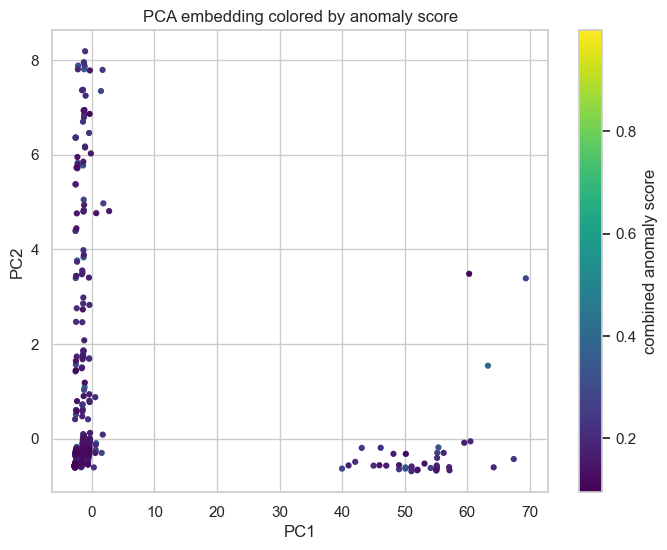

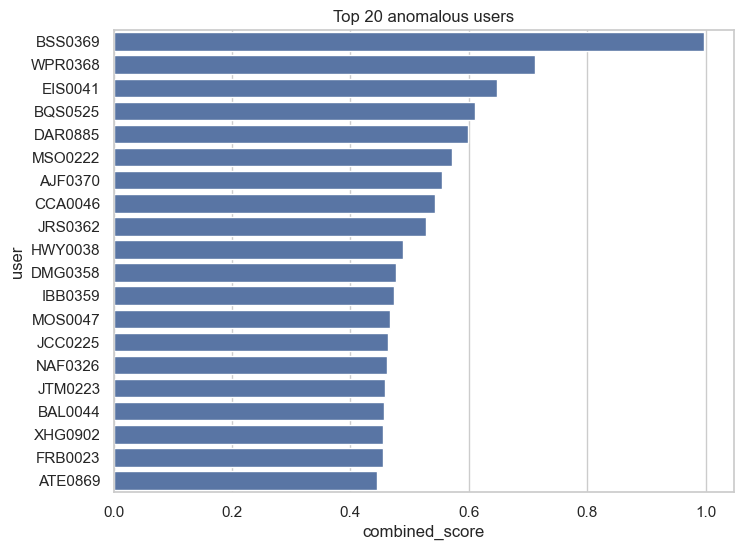

In [12]:
# Cell 12
# PCA scatter colored by combined_score
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=results["combined_score"], cmap='viridis', s=12)
plt.colorbar(label="combined anomaly score")
plt.title("PCA embedding colored by anomaly score")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

# barplot top 20 combined scores
plt.figure(figsize=(8,6))
sns.barplot(x="combined_score", y="user", data=results.head(20))
plt.title("Top 20 anomalous users")
plt.show()


In [13]:
# Step 13: Inspect suspicious users
# Get top 10 most anomalous users
suspicious_users = results.head(10)["user"].tolist()
print("Top suspicious users:", suspicious_users)

# Look at their raw data (from the merged df we used earlier)
df[df["user"].isin(suspicious_users)].head(50)


Top suspicious users: ['BSS0369', 'WPR0368', 'EIS0041', 'BQS0525', 'DAR0885', 'MSO0222', 'AJF0370', 'CCA0046', 'JRS0362', 'HWY0038']


,user,total_logins,unique_days,after_hours,unique_machines,usb_count,usb_days,employee_name,user_id,O,C,E,A,N
34,AJF0370,187,21,107,66,0.0,0.0,Arthur John Floyd,AJF0370,37,33,11,15,36
127,BQS0525,61,27,0,5,0.0,0.0,Britanney Quail Snyder,BQS0525,42,38,19,45,30
134,BSS0369,196,23,118,72,0.0,0.0,Brenden Samuel Shaffer,BSS0369,39,42,34,14,32
160,CCA0046,122,19,93,43,0.0,0.0,Cyrus Connor Atkinson,CCA0046,36,43,25,15,28
238,DAR0885,85,27,12,5,0.0,0.0,Devin Abdul Rogers,DAR0885,43,43,44,41,25
300,EIS0041,189,19,136,70,0.0,0.0,Emerald Imani Schmidt,EIS0041,41,44,17,48,30
436,HWY0038,134,19,100,45,0.0,0.0,Howard Wing Yang,HWY0038,47,39,40,22,24
526,JRS0362,176,19,110,67,0.0,0.0,Jackson Rafael Sutton,JRS0362,50,50,14,37,24
683,MSO0222,126,19,98,44,0.0,0.0,Medge Serina Obrien,MSO0222,32,12,39,46,28
969,WPR0368,182,23,108,63,0.0,0.0,William Price Robles,WPR0368,48,34,40,17,31


Computing score-based permutation importance on 1000 samples (this may take a minute)...


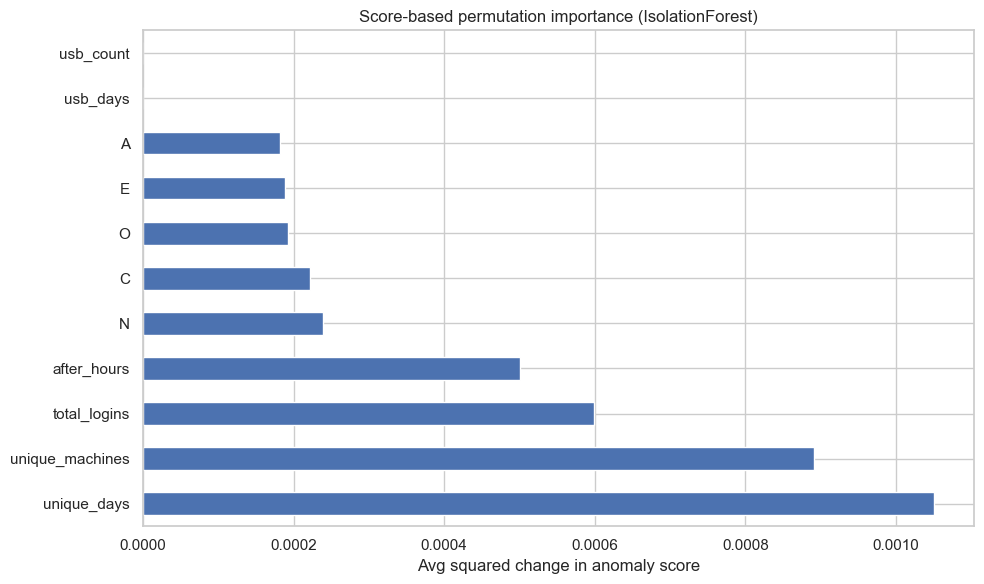

Top features by score-based importance:
 unique_days        0.001051
unique_machines    0.000891
total_logins       0.000599
after_hours        0.000501
N                  0.000239
C                  0.000222
O                  0.000192
E                  0.000188
A                  0.000183
usb_days           0.000000
usb_count          0.000000
dtype: float64

High correlations (>0.85) found:
total_logins <-> unique_machines: 0.896
after_hours <-> unique_machines: 0.894

Negative importances count: 0
Saved score-based importances to results/score_perm_importances.csv


In [18]:
# Step 14 (a) — Score-based permutation importance on anomaly scores
import numpy as np
import pandas as pd

# Compute permutation importance based on change in the model's anomaly scores
def perm_importance_on_scores(clf, X, n_repeats=20, random_state=42):
    rng = np.random.RandomState(random_state)
    X = np.asarray(X)
    n, p = X.shape
    # baseline anomaly scores (using same convention: higher = more anomalous)
    baseline = -clf.score_samples(X)
    importances = np.zeros(p, dtype=float)

    for r in range(n_repeats):
        for j in range(p):
            Xp = X.copy()
            rng.shuffle(Xp[:, j])
            perm_scores = -clf.score_samples(Xp)
            importances[j] += np.mean((baseline - perm_scores) ** 2)

    importances /= n_repeats
    return pd.Series(importances, index=feature_names)

# Use a subset for speed and stability
n_samples = min(1000, X_scaled.shape[0])
print(f"Computing score-based permutation importance on {n_samples} samples (this may take a minute)...")
imp = perm_importance_on_scores(clf, X_scaled[:n_samples], n_repeats=20, random_state=42)
imp_sorted = imp.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,6))
imp_sorted.head(15).plot(kind='barh')
plt.title("Score-based permutation importance (IsolationForest)")
plt.xlabel("Avg squared change in anomaly score")
plt.tight_layout()
plt.show()

print("Top features by score-based importance:\n", imp_sorted.head(15))

# Correlation diagnostics on the numeric features (subset)
import seaborn as sns
X_df_sample = pd.DataFrame(X_scaled[:n_samples], columns=feature_names)
corr = X_df_sample.corr()

high_corr = []
for i in range(len(feature_names)):
    for j in range(i+1, len(feature_names)):
        if abs(corr.iloc[i, j]) > 0.85:
            high_corr.append((feature_names[i], feature_names[j], corr.iloc[i, j]))

if high_corr:
    print("\nHigh correlations (>0.85) found:")
    for a, b, v in high_corr:
        print(f"{a} <-> {b}: {v:.3f}")
else:
    print("\nNo very high correlations (>0.85) found.")

# Check for negative importances (shouldn't occur with this score-based method)
neg_imp = imp[imp < 0]
print(f"\nNegative importances count: {len(neg_imp)}")
if len(neg_imp):
    print(neg_imp.sort_values())

# Save importances to results for later inspection
imp_sorted.to_csv("results/score_perm_importances.csv")
print("Saved score-based importances to results/score_perm_importances.csv")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


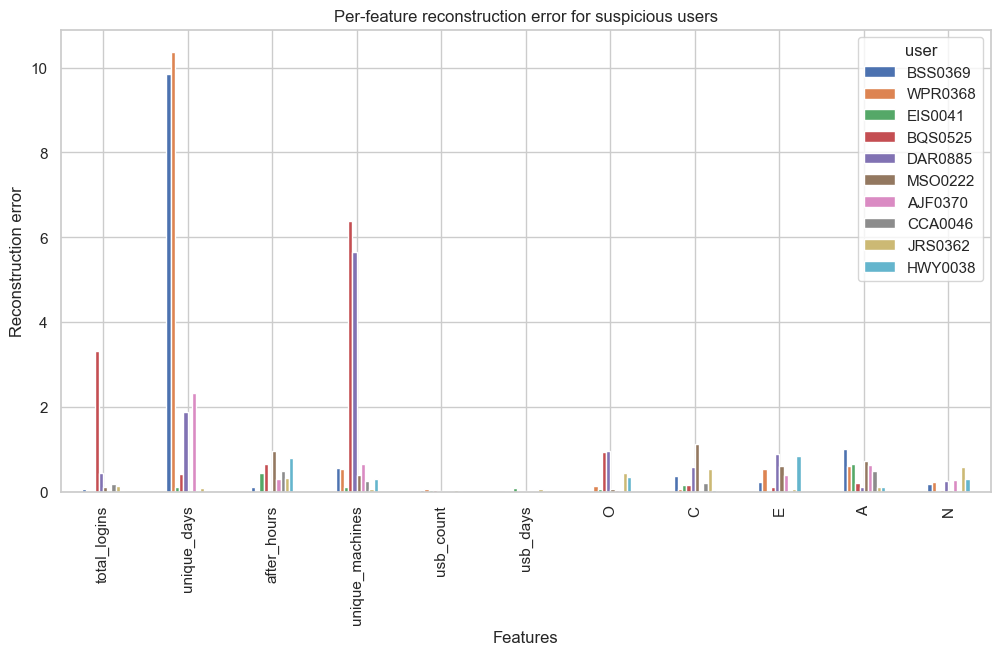

In [16]:
## step 14 (b)
# Compute reconstruction errors per feature
recon = ae.predict(X_scaled)
errors = np.square(X_scaled - recon)

# DataFrame with per-feature error
per_feature_error = pd.DataFrame(errors, columns=feature_names)
per_feature_error["user"] = ids

# Average error per feature for top suspicious users
mean_errors = per_feature_error.groupby("user").mean().loc[suspicious_users]

# Plot
mean_errors.T.plot(kind="bar", figsize=(12,6))
plt.title("Per-feature reconstruction error for suspicious users")
plt.ylabel("Reconstruction error")
plt.xlabel("Features")
plt.show()


In [15]:
import os
import joblib

# Ensure directories exist
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

# Save processed features + scores
results.to_csv("results/anomaly_scores_by_user.csv", index=False)
print("Saved anomaly scores to results/anomaly_scores_by_user.csv")

# Save autoencoder model
ae.save("models/autoencoder.keras")
print("Saved autoencoder model to models/autoencoder.keras")

# Save preprocessing pipeline
joblib.dump(imputer, "models/imputer.joblib")
joblib.dump(scaler, "models/scaler.joblib")
print("Saved imputer & scaler to models/")

# (Optional) Save feature list
with open("models/feature_names.txt", "w") as f:
    for feat in feature_names:
        f.write(feat + "\n")
print("Saved feature names to models/feature_names.txt")


Saved anomaly scores to results/anomaly_scores_by_user.csv
Saved autoencoder model to models/autoencoder.keras
Saved imputer & scaler to models/
Saved feature names to models/feature_names.txt
